In [2]:
# open training file
# link to file with names: https://github.com/karpathy/makemore/blob/master/names.txt
from google.colab import drive

drive.mount('/content/drive')

file_path = 'drive/MyDrive/Colab Notebooks/models/names.txt'

Mounted at /content/drive


In [3]:
# creating array from text file
words = open(file_path, 'r').read().splitlines()
words_adapted = []


for word in words:
  words_adapted.append('.' + word + '.')

# print(words_adapted[:2])

In [4]:
# genereting tokens
tokens = []

for word in words:
  for letter in word:
    if letter not in tokens:
      tokens.append(letter)

tokens.sort()
tokens = ["."] + tokens
tokens_ind = {}
tokens_let = {}
for i in range(len(tokens)):
  tokens_ind[i] = tokens[i]
  tokens_let[tokens[i]] = i

# Bigram(context length - 1 token)

In [5]:
letters_combinations = [[] for _ in range(len(tokens_let))]

for i in range(len(tokens_let)):
  if not letters_combinations[i]:
    letters_combinations[i] = [0] * len(tokens_let)


for word in words_adapted:
  for i in range(len(word) - 1):
    letters_combinations[tokens_let[word[i]]][tokens_let[word[i + 1]]] += 1

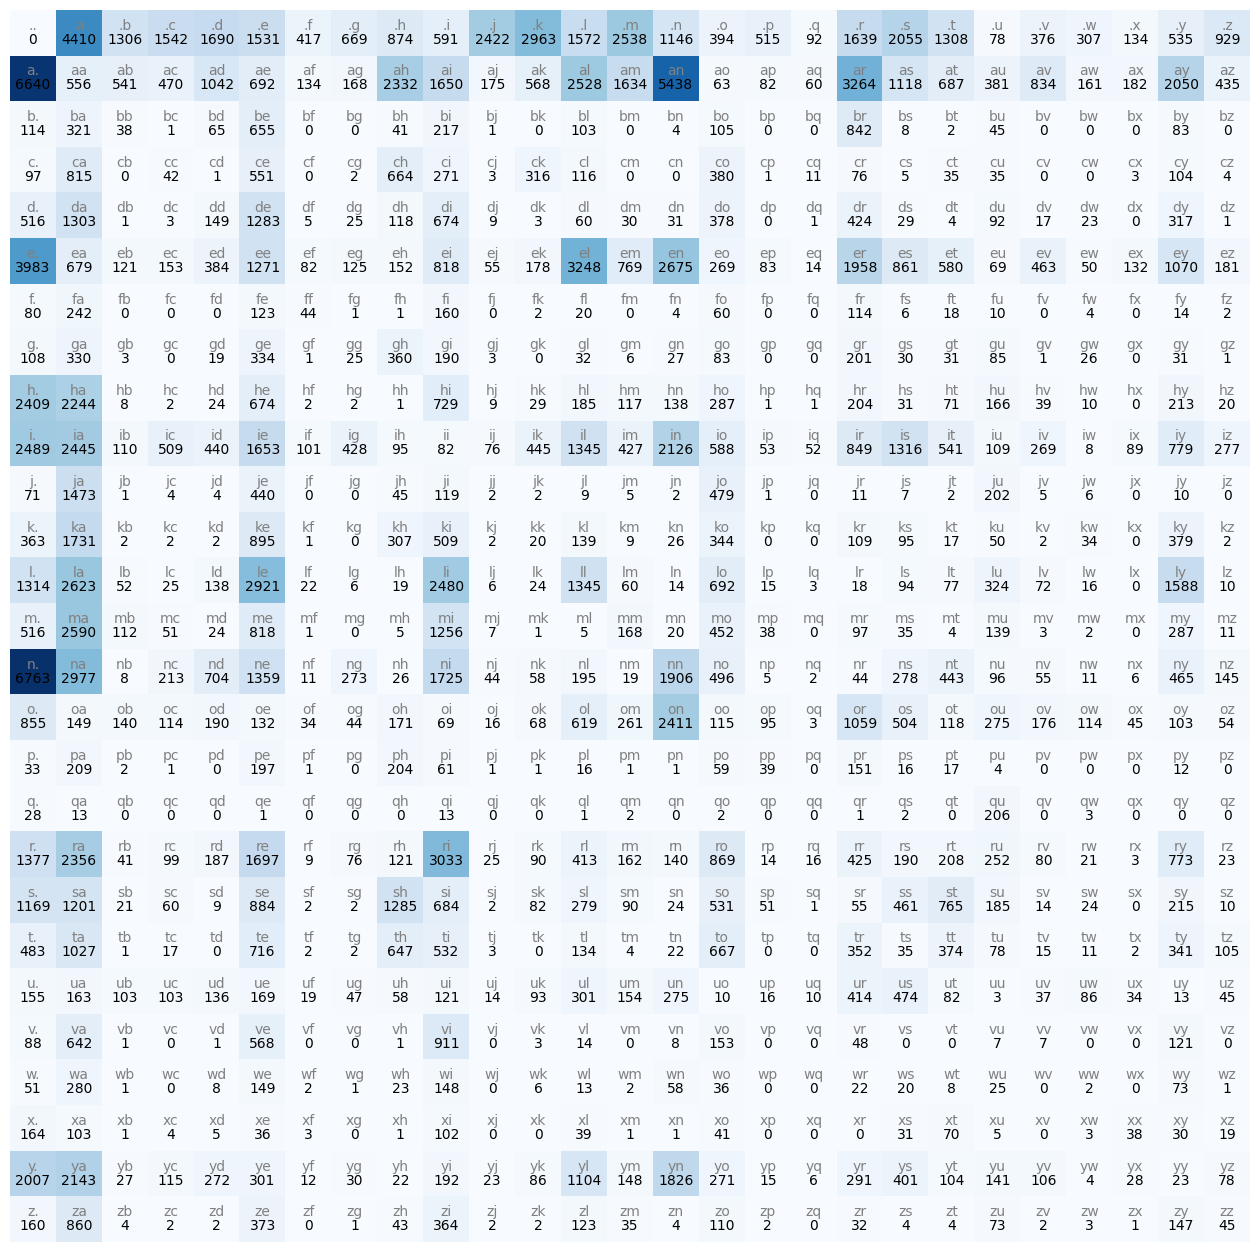

In [6]:
# tokens visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
plt.imshow(letters_combinations, cmap='Blues', aspect='auto')

for i in range(27):
    for j in range(27):
        chstr = tokens_ind[i] + tokens_ind[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, letters_combinations[i][j], ha="center", va="top", color='black')

# Turn off the axis
plt.axis('off')

# Display the plot
plt.show()

In [7]:
#  counting probabilities
import torch
import numpy as np

array = np.array(letters_combinations)

letters_tensor = torch.tensor(array)
letters_prob = torch.zeros(27,27, dtype=torch.float)
for i in range(len(tokens_ind)):
  letters_prob[i] = letters_tensor[i] / letters_tensor[i].sum()

In [8]:
genereted_words = []

for i in range(15):
  n = 0
  word = "."
  while True:
    last_letter_index = tokens_let[word[-1]]
    next_letter = torch.multinomial(letters_prob[last_letter_index], num_samples=1, replacement=True)

    if next_letter == 0:
      break

    word += tokens_ind[next_letter.item()]

  word = word[1:]
  genereted_words.append(word)

print([word for word in genereted_words])


['yalaulan', 'milmie', 'han', 'dssa', 'dorarasa', 'janonadie', 'y', 'wle', 'kinniemakinen', 'jautohawasetit', 'ja', 'maydas', 'roloieniepriash', 'n', 'cadan']


In [9]:
g = torch.Generator().manual_seed(123)
p = torch.rand(3, 6, generator=g)

prob = p[0] / p[0].sum()

prob_mul = torch.multinomial(prob, num_samples=1, replacement=True)

print(prob, prob_mul)

tensor([0.1099, 0.1918, 0.0934, 0.2556, 0.0275, 0.3217]) tensor([5])


# Bigram(context length - 2 token)

In [10]:
# creating array from text file
words = open(file_path, 'r').read().splitlines()
words_adapted = []


for word in words:
  words_adapted.append('..' + word + '..')

letters_combinations = [[] for _ in range(len(tokens_let))]

for i in range(len(tokens_let)):
  if not letters_combinations[i]:
    letters_combinations[i] = [0] * len(tokens_let)

    for j in range(len(tokens_let)):
      letters_combinations[i][j] = [0] * len(tokens_let)


for word in words_adapted:
  for i in range(len(word) - 2):
    letters_combinations[tokens_let[word[i]]][tokens_let[word[i + 1]]][tokens_let[word[i + 2]]] += 1

letters_combinations = torch.tensor(letters_combinations)
letters_combinations += 1

In [11]:
#  counting probabilities
import torch
import numpy as np

array = np.array(letters_combinations)

letters_tensor = torch.tensor(array)
letters_prob = torch.zeros(27, 27, 27, dtype=torch.float)
for i in range(len(tokens_ind)):
  for j in range(len(tokens_ind)):
    letters_prob[i][j] = letters_tensor[i][j] / letters_tensor[i][j].sum()

In [12]:
genereted_words = []

for i in range(15):
  n = 0
  word = ".."
  while True:
    last_letter_index = tokens_let[word[-1]]
    previous_letter_index =tokens_let[word[-2]]
    next_letter = torch.multinomial(letters_prob[previous_letter_index][last_letter_index], num_samples=1, replacement=True)

    if next_letter == 0:
      break

    word += tokens_ind[next_letter.item()]

  word = word[2:]
  genereted_words.append(word)

print([word for word in genereted_words])


['bionyhellia', 'hwtmeigo', 'camila', 'ri', 'lanna', 'elaroodaidemarell', 'bow', 'kain', 'amany', 'drickas', 'is', 'kynne', 'nicorawamin', 'ken', 'omy']


In [14]:
# Counting likelihood
sum = 0
n = 0

for word in words_adapted:
  word = "something"

  for i in range(len(word) - 2):
    n += 1
    # print("input:", tokens_let[word[i]], tokens_let[word[i + 1]], "Output:", tokens_let[word[i + 2]])
    p_log = torch.log(letters_prob[tokens_let[word[i]]][tokens_let[word[i + 1]]][tokens_let[word[i + 2]]])
    sum += p_log

print(sum / n)

tensor(-2.5473)


# Bigram NN version (1 letter kontext)



In [28]:
import torch.nn.functional as F

# creating array from text file
words = open(file_path, 'r').read().splitlines()
words_adapted = []


for word in words:
  words_adapted.append('.' + word + '.')

# print(words_adapted[:2])

In [110]:
# genereting tokens
tokens = []

for word in words:
  for letter in word:
    if letter not in tokens:
      tokens.append(letter)

tokens.sort()
tokens = ["."] + tokens
tokens_ind = {}
tokens_let = {}
for i in range(len(tokens)):
  tokens_ind[i] = tokens[i]
  tokens_let[tokens[i]] = i

In [127]:
# genereting training arrays
input_ar = []
output_ar = []

for word in words_adapted:
  for i in range(len(word) - 1):
    input_ar += [tokens_let[word[i]]]
    output_ar += [tokens_let[word[i + 1]]]

input_ar = torch.tensor(input_ar)
output_ar = torch.tensor(output_ar)
count = input_ar.nelement()
print(input_ar, output_ar)

# Creatings weights
g = torch.Generator().manual_seed(2)
W = torch.randn((27, 27), generator=g, requires_grad=True)

tensor([ 0,  5, 13,  ..., 25, 26, 24]) tensor([ 5, 13, 13,  ..., 26, 24,  0])


In [139]:
for k in range(1):
  input = F.one_hot(input_ar, num_classes=len(tokens_let))
  input = input.to(torch.float)
  logits = input @ W
  counts = logits.exp()
  prob = counts / counts.sum(1, keepdim=True)
  loss = -prob[torch.arange(count), output_ar].log().mean()

  W.grad = None
  loss.backward()
  W.data += -50 * W.grad

  print(loss)

tensor(2.4607, grad_fn=<NegBackward0>)


# Bigram NN version (2 letter kontext)



In [144]:
import torch.nn.functional as F

# creating array from text file
words = open(file_path, 'r').read().splitlines()
words_adapted = []


for word in words:
  words_adapted.append('..' + word + '..')

In [145]:
# genereting tokens
tokens = []

for word in words:
  for letter in word:
    if letter not in tokens:
      tokens.append(letter)

tokens.sort()
tokens = ["."] + tokens
tokens_ind = {}
tokens_let = {}
for i in range(len(tokens)):
  tokens_ind[i] = tokens[i]
  tokens_let[tokens[i]] = i

In [173]:
# genereting training arrays
input_ar = []
output_ar = []

for word in words_adapted:
  for i in range(len(word) - 2):
    input_ar += [[tokens_let[word[i]], tokens_let[word[i + 1]]]]
    output_ar += [tokens_let[word[i + 2]]]

input_ar = torch.tensor(input_ar)
output_ar = torch.tensor(output_ar)
count = output_ar.nelement()
print(input_ar, output_ar)

# Creatings weights
context_length = 2
g = torch.Generator().manual_seed(2)
W = torch.randn((27 * context_length, 27), generator=g, requires_grad=True)

tensor([[ 0,  0],
        [ 0,  5],
        [ 5, 13],
        ...,
        [25, 26],
        [26, 24],
        [24,  0]]) tensor([ 5, 13, 13,  ..., 24,  0,  0])


In [180]:
for k in range(1):
  input = F.one_hot(input_ar, num_classes=len(tokens_let))
  input = input.reshape(-1, 1, 27 * context_length)
  input = input.to(torch.float)
  logits = input @ W
  logits = logits.reshape(-1, 27)
  counts = logits.exp()
  prob = counts / counts.sum(1, keepdim=True)
  loss = -prob[torch.arange(count), output_ar].log().mean()

  W.grad = None
  loss.backward()
  W.data += -5 * W.grad

  print(loss)

tensor(2.0786, grad_fn=<NegBackward0>)


In [188]:
genereted_words = []

def predict_next_letter(last, prev):
  input_ar = torch.tensor([prev, last])
  input = F.one_hot(input_ar, num_classes=len(tokens_let))
  input = input.reshape(-1, 1, 27 * context_length)
  input = input.to(torch.float)
  logits = input @ W
  logits = logits.reshape(-1, 27)
  counts = logits.exp()
  prob = counts / counts.sum(1, keepdim=True)
  next_letter = torch.multinomial(prob, num_samples=1, replacement=True)
  return next_letter


for i in range(10):
  n = 0
  word = ".."
  while True:
    last_letter_index = tokens_let[word[-1]]
    previous_letter_index = tokens_let[word[-2]]

    next_letter = predict_next_letter(last_letter_index, previous_letter_index)

    if next_letter == 0:
      break

    word += tokens_ind[next_letter.item()]

  word = word[2:]
  genereted_words.append(word)

print([word for word in genereted_words])

['ca', 'amitacara', 'oall', 'kareezmajhai', 'zucilia', 'bhslanie', 'allaitb', 'lananianile', 'genole', 'delsiahmiradal']
